In [1]:
from pathlib import Path

import mml.interactive

mml.interactive.init(Path('~/.config/mml.env').expanduser())

# patch cache path to use a different storage for distances and exps
import mml_tf.paths

mml_tf.paths.CACHE_PATH = mml_tf.paths.CACHE_PATH.parent / 'MSD_cache'

from mml_tf.paths import DATA_PATH, FIG_PATH, CACHE_PATH
# patch get_valid_sources
from typing import List, Optional, Tuple

msd_tasks = [
    'Dataset001_BrainTumour',
    'Dataset002_Heart',
    'Dataset003_Liver',
    'Dataset004_Hippocampus',
    'Dataset005_Prostate',
    'Dataset006_Lung',
    'Dataset007_Pancreas',
    'Dataset008_HepaticVessel',
    'Dataset009_Spleen',
    'Dataset010_Colon'
]
abb = {full: short for (full, short) in zip(msd_tasks, ['BRATS', 'Heart', 'Liver', 'Hippocampus', 'Prostate', 'Lung',
                                                        'Pancreas', 'Hepatic Vessel', 'Spleen', 'Colon'])}
n_regions_per_task = {'BRATS': 3, 'Heart': 1, 'Hippocampus': 2, 'Liver': 2, 'Lung': 1, 'Pancreas': 2, 'Prostate': 2,
                      'Hepatic Vessel': 2, 'Spleen': 1, 'Colon': 1}


# patch the get_valid_sources function (will be used in calc_corr and calc_top_k)
def get_msd_valid_sources(target_task: str, min_samples: int = 1) -> List[str]:
    return [t for t in msd_tasks if t != target_task]


import mml_tf.tasks

mml_tf.tasks.get_valid_sources = get_msd_valid_sources

# remaining imports
import pandas as pd
import numpy as np
from collections import Counter
from mml_tf.representations import FullFeatureRepresentations, BinnedFeatureRepresentations, \
    AveragedFeatureRepresentations, MeanAndCovarianceRepresentations, TagBasedRepresentations
from tqdm.notebook import tqdm
from mml_tf.distances import KLDDistances, EMDDistances, LoadCachedDistances, FIDDistances, SemanticDistances, MMDDistances
from mml_tf.ranking import BootstrapRanking
from mml_tf.distances import map_dist2printable
from mml_tf.visualization import init_colors, get_dist_measure_color
import plotly.express as px
import plotly.graph_objects as go

 _____ ______   _____ ______   ___
|\   _ \  _   \|\   _ \  _   \|\  \
\ \  \\\__\ \  \ \  \\\__\ \  \ \  \
 \ \  \\|__| \  \ \  \\|__| \  \ \  \
  \ \  \    \ \  \ \  \    \ \  \ \  \____
   \ \__\    \ \__\ \__\    \ \__\ \_______\
    \|__|     \|__|\|__|     \|__|\|_______|
         ____  _  _    __  _  _  ____  _  _
        (  _ \( \/ )  (  )( \/ )/ ___)( \/ )
         ) _ ( )  /    )( / \/ \\___ \ )  /
        (____/(__/    (__)\_)(_/(____/(__/
Interactive MML API initialized.


## Step 1: Inspect MSD results

In [4]:
# download MSD results
if (CACHE_PATH / 'msd_results.csv').exists():
    msd_results = pd.read_csv(CACHE_PATH / 'msd_results.csv',header=[0, 1, 2], index_col=0)
else:
    tables_on_page = pd.read_html('http://medicaldecathlon.com/results/', header=[0, 1, 2], index_col=0)
    phase_one_results = tables_on_page[0].copy().drop(columns=[tables_on_page[0].columns.tolist()[0]])
    phase_two_results = tables_on_page[1].copy().drop(columns=[tables_on_page[1].columns.tolist()[0]])
    msd_results = pd.concat((phase_one_results, phase_two_results), axis='columns')
    msd_results.to_csv(CACHE_PATH / 'msd_results.csv')
# show results
msd_results

BRATS                               Heart       Hippocampus  \
                 Dice               NSD              Dice   NSD        Dice   
Team               L1    L2    L3    L1    L2    L3    L1    L1          L1   
nnU-Net          0.68  0.48  0.68  0.87  0.73  0.91  0.93  0.96        0.90   
K.A.V.athlon     0.67  0.47  0.67  0.88  0.73  0.90  0.92  0.95        0.90   
NVDLMED          0.68  0.45  0.68  0.87  0.70  0.90  0.92  0.96        0.88   
Lupin            0.66  0.42  0.64  0.88  0.68  0.89  0.92  0.97        0.90   
CerebriuDIKU     0.70  0.43  0.67  0.88  0.69  0.89  0.89  0.91        0.90   
LS Wang's Group  0.68  0.46  0.66  0.87  0.70  0.87  0.90  0.92        0.90   
MIMI             0.65  0.44  0.66  0.88  0.70  0.89  0.90  0.92        0.89   
Whale            0.64  0.30  0.23  0.85  0.54  0.55  0.89  0.91        0.86   
VST              0.54  0.30  0.63  0.78  0.54  0.82  0.89  0.92        0.86   
UBIlearn         0.65  0.37  0.62  0.85  0.63  0.85  0.91  0.94        0.89   
BCVuniandes      0.69  0.43  0.65  0.88  0.69  0.88  0.80  0.83        0.89   
BUT              0.64  0.35  0.62  0.86  0.59  0.84  0.76  0.79        0.83   
A-REUMI01        0.64  0.40  0.64  0.84  0.64  0.85  0.90  0.91        0.88   
LfB              0.60  0.44  0.62  0.83  0.68  0.80  0.91  0.93        0.79   
SIAT_MIDS        0.33  0.27  0.31  0.62  0.37  0.56  0.88  0.91        0.88   
Lesswire1        0.63  0.41  0.58  0.81  0.68  0.84  0.72  0.73        0.80   
AI-Med           0.64  0.35  0.61  0.83  0.62  0.85  0.76  0.75        0.83   
RegionTec        0.42  0.35  0.55  0.67  0.62  0.82  0.63  0.68        0.72   
EdwardMa12593    0.37  0.01  0.18  0.58  0.11  0.38  0.73  0.70        0.87   

                       ... Prostate       Hepatic Vessel                    \
                       ...      NSD                 Dice         NSD         
Team               L2  ...       L1    L2             L1    L2    L1    L2   
nnU-Net          0.89  ...     0.96  0.99           0.63  0.69  0.83  0.79   
K.A.V.athlon     0.89  ...     0.95  0.98           0.62  0.63  0.83  0.72   
NVDLMED          0.87  ...     0.93  0.97           0.63  0.64  0.83  0.72   
Lupin            0.88  ...     0.94  0.98           0.60  0.47  0.81  0.54   
CerebriuDIKU     0.88  ...     0.95  0.98           0.59  0.38  0.79  0.44   
LS Wang's Group  0.89  ...     0.96  0.98           0.55  0.64  0.77  0.73   
MIMI             0.88  ...     0.94  0.98           0.60  0.56  0.79  0.64   
Whale            0.85  ...     0.95  0.98           0.56  0.46  0.80  0.57   
VST              0.87  ...     0.93  0.97           0.44  0.36  0.58  0.39   
UBIlearn         0.85  ...     0.93  0.96           0.59  0.37  0.80  0.42   
BCVuniandes      0.88  ...     0.94  0.98           0.14  0.32  0.45  0.36   
BUT              0.83  ...     0.92  0.97           0.44  0.39  0.65  0.45   
A-REUMI01        0.86  ...     0.93  0.98           0.56  0.39  0.79  0.46   
LfB              0.84  ...     0.89  0.96           0.55  0.35  0.79  0.37   
SIAT_MIDS        0.86  ...     0.94  0.98           0.51  0.37  0.73  0.39   
Lesswire1        0.77  ...     0.86  0.92           0.44  0.31  0.73  0.28   
AI-Med           0.73  ...     0.85  0.87           0.42  0.26  0.65  0.33   
RegionTec        0.70  ...     0.72  0.78           0.42  0.20  0.69  0.22   
EdwardMa12593    0.87  ...     0.79  0.93           0.14  0.11  0.31  0.12   

                Spleen       Colon        
                  Dice   NSD  Dice   NSD  
Team                L1    L1    L1    L1  
nnU-Net           0.96  0.99  0.56  0.68  
K.A.V.athlon      0.97  1.00  0.36  0.47  
NVDLMED           0.96  1.00  0.56  0.66  
Lupin             0.94  0.98  0.09  0.16  
CerebriuDIKU      0.95  0.98  0.28  0.43  
LS Wang's Group   0.96  0.99  0.41  0.51  
MIMI              0.94  0.97  0.29  0.38  
Whale             0.95  0.99  0.18  0.29  
VST               0.94  0.97  0.15  0.22  
UBIlearn          0.95  0.98  0.16  0.25  
B

Counter({'nnU-Net': 29, 'K.A.V.athlon': 3, 'CerebriuDIKU': 1, 'Lupin': 1})


<Axes: >

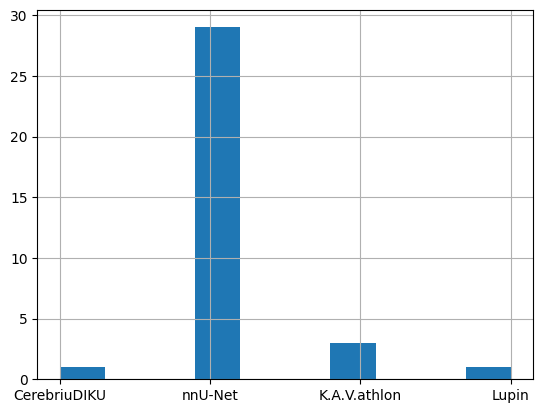

In [3]:
# "unfortunately" the distribution of "best models" is rather skewed
print(Counter(msd_results.rank().idxmax().values))
msd_results.rank().idxmax().hist()

In [4]:
# this means "any" task similarity measure would transfer very good, we thus have to use a more complex outcome to compare computed task similarity with
msd_results.corr()

BRATS                                          \
                              Dice                           NSD             
Team                            L1        L2        L3        L1        L2   
                    Team                                                     
BRATS          Dice L1    1.000000  0.758854  0.697211  0.979292  0.808304   
                    L2    0.758854  1.000000  0.839073  0.814505  0.976490   
                    L3    0.697211  0.839073  1.000000  0.725210  0.858780   
               NSD  L1    0.979292  0.814505  0.725210  1.000000  0.851123   
                    L2    0.808304  0.976490  0.858780  0.851123  1.000000   
                    L3    0.735151  0.890249  0.979912  0.768063  0.922122   
Heart          Dice L1    0.452452  0.440995  0.285752  0.525547  0.342827   
               NSD  L1    0.459509  0.523984  0.353098  0.552803  0.428340   
Hippocampus    Dice L1    0.384427  0.143837  0.118411  0.379413  0.055826   
                    L2    0.286899  0.129919  0.079802  0.314306  0.018189   
               NSD  L1    0.372943  0.122677  0.083430  0.354673  0.037810   
                    L2    0.207156  0.076733 -0.003539  0.233711 -0.036771   
Liver          Dice L1    0.688540  0.654038  0.614301  0.756830  0.698468   
                    L2    0.809884  0.722767  0.595309  0.851253  0.739853   
               NSD  L1    0.490842  0.540009  0.434355  0.569925  0.555827   
                    L2    0.810308  0.729117  0.553291  0.846035  0.742508   
Lung           Dice L1    0.534520  0.590177  0.364438  0.608815  0.480278   
               NSD  L1    0.549008  0.607636  0.386223  0.628570  0.505256   
Pancreas       Dice L1    0.539140  0.570410  0.524480  0.597782  0.550327   
                    L2    0.427155  0.542405  0.399877  0.502205  0.469364   
               NSD  L1    0.657385  0.601123  0.589508  0.682891  0.646003   
                    L2    0.477494  0.647182  0.513168  0.560376  0.579767   
Prostate       Dice L1    0.559883  0.495521  0.354265  0.639087  0.410222   
                    L2    0.613319  0.454167  0.308038  0.672671  0.376494   
               NSD  L1    0.595392  0.501020  0.324761  0.660695  0.409537   
                    L2    0.425093  0.242911  0.121145  0.466511  0.133578   
Hepatic Vessel Dice L1    0.420320  0.615924  0.401993  0.504168  0.567286   
                    L2    0.588102  0.682987  0.466433  0.644469  0.599017   
               NSD  L1    0.473725  0.723568  0.431203  0.553132  0.678603   
                    L2    0.609842  0.658268  0.441471  0.664740  0.585264   
Spleen         Dice L1    0.267800  0.370402  0.253011  0.327283  0.350746   
               NSD  L1    0.325505  0.422781  0.256779  0.400985  0.379782   
Colon          Dice L1    0.382408  0.512480  0.352333  0.383347  0.415977   
               NSD  L1    0.460121  0.548800  0.373425  0.442747  0.463388   

                                       Heart           Hippocampus            \
                                        Dice       NSD        Dice             
Team                            L3        L1        L1          L1        L2   
                    Team                                                       
BRATS          Dice L1    0.735151  0.452452  0.459509    0.384427  0.286899   
                    L2    0.890249  0.440995  0.523984    0.143837  0.129919   
                    L3    0.979912  0.285752  0.353098    0.118411  0.079802   
               NSD  L1    0.768063  0.525547  0.552803    0.379413  0.314306   
                    L2    0.922122  0.342827  0.428340    0.055826  0.018189   
                    L3    1.000000  0.255111  0.339727    0.087436  0.007658   
Heart          Dice L1    0.255111  1.000000  0.981485    0.729036  0.778941   
               NSD  L1    0.339727  0.981485  1.000000    0.670835  0.739955   
Hippocampus    Dice L1    0.087436  0.729036  0.670835    1.000000  0.862838   
                    L2  

## Step 2: Compute distances

(may be skipped if using cached distances)

In [16]:
# the features for MSD have been generated using nnssl with an MAE, to load that format we use a dedicated class
class MSDFullFeaturesRepresentation(FullFeatureRepresentations):
    def __init__(self, reduce_dims: Optional[List[int]] = None):
        """
        Initialize MSD Features Representation

        :param reduce_dims: dimensions to reduce features (default: None)
        """
        # Sort dimensions in reverse order to avoid changing indices
        self.reduction_dims = tuple(sorted(reduce_dims, reverse=True)) if reduce_dims is not None else tuple([])
        assert all([0 <= dim <= 3 for dim in self.reduction_dims]), 'dim out of bounds'
        assert len(set(reduce_dims)) == len(reduce_dims), 'duplicate dimensions'
        super().__init__(task_list=msd_tasks, folder='nnssl_results',
                         probe_network='_'.join([str(dim) for dim in self.reduction_dims]))

    def load_representations(self):
        """Load and reduce features from .npz files."""

        for task in tqdm(self.task_list, desc='loading tasks'):
            all_features = []
            _feat_path = DATA_PATH / self.folder / task / 'BaseMAETrainer_feature__nnsslPlans__onemmiso' / 'fold_all' / 'img_log' / 'feat'
            for feat_file in tqdm(_feat_path.iterdir(), total=10_000, leave=False, desc=f'{task}'):
                # Load the .npz file for each sample in the task (shape: (320, 5, 5, 5))
                features = np.load(feat_file)['features']

                # Reduce dimensions if specified
                if self.reduction_dims:
                    features = np.mean(features, axis=self.reduction_dims)

                # Flatten the remaining dimensions
                features = features.reshape(-1)
                all_features.append(features)

            # Stack all features to create n_samples x n_features matrix
            assert len(all_features) == 10_000
            self.mapping[task] = np.vstack(all_features)
        assert self.is_loaded()

In [17]:
# in our experiments we maximise feature reduction, resulting in 320 features
ff = MSDFullFeaturesRepresentation(reduce_dims=[1, 2, 3])
ff.load_representations()

loading tasks:   0%|          | 0/10 [00:00<?, ?it/s]

Dataset001_BrainTumour:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset002_Heart:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset003_Liver:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset004_Hippocampus:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset005_Prostate:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset006_Lung:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset007_Pancreas:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset008_HepaticVessel:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset009_Spleen:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset010_Colon:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
# these are all representations used
lot_bins_rep = BinnedFeatureRepresentations(full_features=ff, n_bins=1000)
few_bins_rep = BinnedFeatureRepresentations(full_features=ff, n_bins=100)
avg_rep = AveragedFeatureRepresentations(full_features=ff)
mean_cov_rep = MeanAndCovarianceRepresentations(full_features=ff)
tag_rep = TagBasedRepresentations(task_list=msd_tasks)
tiny_bins_rep = BinnedFeatureRepresentations(full_features=ff, n_bins=5, min_q=0.,
                                             max_q=0.9)  # unused but part of our development hp search phase
for rep in [lot_bins_rep, few_bins_rep, avg_rep, mean_cov_rep, tag_rep, tiny_bins_rep]:
    rep.load_representations()

In [20]:
# these are the main based distances compared (we excluded FED for the complexity and number of hyperparameters)
sem = SemanticDistances(representations=tag_rep, source_tasks=msd_tasks, target_tasks=msd_tasks)
kld_small_target = KLDDistances(representations=few_bins_rep, source_pp='soft', target_pp='norm', invert=False,
                                weighing_by='target', weights_rep=avg_rep, weights_pp='soft', clip=False, cache=True,
                                source_tasks=msd_tasks, target_tasks=msd_tasks, zscore_axis=0)
kld_large_source = KLDDistances(representations=lot_bins_rep, source_pp='soft', target_pp='norm', invert=False,
                                weighing_by='source', weights_rep=avg_rep, weights_pp='norm', clip=False, cache=True,
                                source_tasks=msd_tasks, target_tasks=msd_tasks, zscore_axis=0)
kld_large_unweighted = KLDDistances(representations=lot_bins_rep, source_pp='soft', target_pp='norm', invert=False,
                                    weights_rep=None, clip=False, cache=True, source_tasks=msd_tasks,
                                    target_tasks=msd_tasks, zscore_axis=0)
vdna = EMDDistances(representations=lot_bins_rep, soft_features=False, source_tasks=msd_tasks, target_tasks=msd_tasks,
                    zscore_axis=0)
p2l = KLDDistances(representations=avg_rep, source_pp='norm', target_pp='norm', source_tasks=msd_tasks,
                   target_tasks=msd_tasks, zscore_axis=0)
fid = FIDDistances(representations=mean_cov_rep, source_tasks=msd_tasks, target_tasks=msd_tasks, zscore_axis=0)

mmd = MMDDistances(representations=ff, kernel='geo-sinkhorn', blur=0.01, source_tasks=msd_tasks, target_tasks=msd_tasks, zscore_axis=0)

Output()

Output()

## Step 3: Evaluate distances

In [2]:
paper_variants = ['KLD-PP:NS-1000-BINS-3_2_1',
                  # 'KLD-PP:NS-W:SN-1000-BINS-3_2_1',
                  'KLD-PP:NS-W:TS-100-BINS-3_2_1',
                  'VDNA-PP:NN-1000-BINS-3_2_1', 'KLD-PP:NN-3_2_1', 'FID-3_2_1', 'SEMANTIC', 'MMD-geo-sinkhorn-0.01-3_2_1']
all_distances = {name: LoadCachedDistances(name, zscore_axis=0) for name in paper_variants}

In [5]:
from mml_tf.evaluation import calc_corr, calc_top_k

# these two models occasionally "fail", i.e. they have tasks with performance zero
_model_exclude_list = ['RegionTec', 'EdwardMa12593']

evaluation_rows = []
for metric in ['Dice', 'NSD']:
    # for subset_idx, model_subset in enumerate(combinations(msd_results.index.tolist(), r=1)):
    for subset_idx in range(1):
        challenge_corr = msd_results.drop(index=_model_exclude_list).corr('pearson')
        # challenge_corr = msd_results.loc[list(model_subset)].corr('pearson')
        for target in msd_tasks:
            for target_subtask_idx in range(n_regions_per_task[abb[target]]):
                # we have to build "exp_df" for this combination
                exp_df = pd.DataFrame(index=msd_tasks, columns=msd_tasks)
                for source in msd_tasks:
                    if source == target:
                        continue
                    # we average over all regions in the source task
                    _measured_values = []
                    for source_subtask_idx in range(n_regions_per_task[abb[source]]):
                        _measured_values.append(challenge_corr.at[
                                                    (abb[source], metric, 'L' + str(source_subtask_idx + 1)), (
                                                        abb[target], metric, 'L' + str(target_subtask_idx + 1))])
                    exp_df.at[source, target] = np.mean(_measured_values)
                for dist in all_distances.values():
                    score = calc_corr(distances=dist, meta_metric='weightedtau', exp_results=exp_df,
                                      target_task=target, shrunk=False, is_loss=False,
                                      min_samples=1)
                    evaluation_rows.append({'exp': 'MSD', 'distances': dist.name, 'metric': metric,
                                            'seed': str(target_subtask_idx), 'target': target,
                                            'meta metric': 'weightedtau',
                                            'score': score})
                    for top_k_meta_metric in ['regret', 'delta', 'rank']:
                        score = calc_top_k(distances=dist, meta_metric=top_k_meta_metric, exp_results=exp_df,
                                           target_task=target, top_k=3, baseline=challenge_corr.mean().loc[
                                (abb[target], metric, 'L' + str(target_subtask_idx + 1))],
                                           # we use mean transferability as baseline
                                           shrunk=False, mode='avg', is_loss=False,
                                           min_samples=1)
                        evaluation_rows.append(
                            {'exp': 'MSD', 'distances': dist.name, 'metric': metric,
                             'seed': str(target_subtask_idx) + '_' + str(subset_idx), 'target': target,
                             'meta metric': top_k_meta_metric,
                             'score': score})
evaluations_df = pd.DataFrame(evaluation_rows)

## Step 4: Plot results

In [6]:
map_msd_dist_to_orig = {d: d[:-6] if d.endswith('-3_2_1') else d for d in all_distances}
map_dist2printable['MMD-geo-sinkhorn-0.01'] = 'MMD'
plot_order = [map_dist2printable[d] for d in
              ['SEMANTIC', 'VDNA-PP:NN-1000-BINS', 'FED', 'FID', 'KLD-PP:NN', 'MMD-geo-sinkhorn-0.01', 'KLD-PP:NS-W:TS-100-BINS',
               # 'KLD-PP:NS-W:SN-1000-BINS',
               'KLD-PP:NS-1000-BINS']]
init_colors(exp=['MSD'], distance_measures=plot_order)
color_map = {dist: get_dist_measure_color(dist) for dist in plot_order}
symbol_map = {d: 'circle' for d in plot_order}
# symbol_map[map_dist2printable['KLD-PP:NS-W:SN-1000-BINS']] = 'hexagon'
symbol_map[map_dist2printable['KLD-PP:NS-1000-BINS']] = 'hexagram'
dash_map = {d: 'solid' for d in plot_order}
# dash_map[map_dist2printable['KLD-PP:NS-W:SN-1000-BINS']] = 'dash'
dash_map[map_dist2printable['KLD-PP:NS-1000-BINS']] = 'dot'

In [7]:
# similar to notebook three
def get_bubble_ranking_plot(
        distances: List[str],
        meta_metric: str = "regret",
        use_median: bool = False,  # if True median instead of mean is used upon ranks
        inverted: bool = False,  # inverts orientation of the y-axis (such that low ranks are at the top)
) -> Tuple[go.Figure, pd.DataFrame]:
    rr_df = pd.DataFrame()
    sub_evals = evaluations_df[
        evaluations_df['distances'].isin(distances) & (evaluations_df['meta metric'] == meta_metric)]
    rr_df['case'] = sub_evals['seed'] + sub_evals['metric'] + sub_evals['target']
    rr_df['task'] = 'MSD'
    rr_df['algorithm'] = sub_evals['distances']
    rr_df['value'] = sub_evals['score']
    rr_df = rr_df.replace(map_msd_dist_to_orig)
    rr_df = rr_df.replace(map_dist2printable)
    bsr = BootstrapRanking(data=rr_df, use_median=use_median)
    alg_order = list(bsr.statistics.algorithm.values)  # determine ordering
    if inverted:
        alg_order = alg_order[::-1]
    df_counts = bsr.counts.sort_values(by="algorithm", key=lambda column: column.map(lambda e: alg_order.index(e)))
    fig = px.scatter(df_counts, x='algorithm', y='rank', color='algorithm', size='count', template='plotly',
                     title=meta_metric, labels={'rank': 'Rank', 'algorithm': 'Algorithm'}, color_discrete_map=color_map,
                     symbol='algorithm', symbol_map=symbol_map)
    fig.update_layout(showlegend=False)
    fig.add_scatter(x=bsr.statistics['algorithm'], y=bsr.statistics['mean_rank'],
                    error_y={'array': bsr.statistics['std_rank']}, marker_symbol='x-thin', marker_size=15,
                    marker_line_width=2, marker_color='black', mode='markers')
    if inverted:
        fig.update_yaxes(autorange='reversed')
    return fig, bsr.statistics

In [9]:
from plotly.subplots import make_subplots

# we use the meta metrics explained in the paper (except for gain, as it is a less granular version of improve)
_meta_metrics = ['regret', 'rank', 'delta', 'weightedtau']
# map the internal names to the ones of the paper
mm_display_map = {'regret': 'Regret', 'rank': 'Percentile', 'delta': 'Improvement', 'weightedtau': 'Weightedtau'}
_inverted = True
_tripled = True
express_figs = []
statistics_collector = []
for meta_metric in _meta_metrics:
    fig, stats = get_bubble_ranking_plot(distances=all_distances, meta_metric=meta_metric, inverted=_inverted)
    express_figs.append(fig)
    statistics_collector.append(stats)
fig = make_subplots(rows=1, cols=4, shared_xaxes=False, shared_yaxes=True, vertical_spacing=0.01,
                    horizontal_spacing=0.01,
                    column_titles=[mm_display_map[m] for m in _meta_metrics],
                    row_titles=['Medical Segmentation Decathlon'],
                    y_title='Rank')
for fig_idx, sub_fig in enumerate(express_figs):
    row = 1 + fig_idx // 4
    col = 1 + fig_idx % 4
    for trace in sub_fig.data:
        fig.add_trace(trace, row=row, col=col)
fig.update_layout(template='plotly', height=500, width=1200, font_size=20, legend_title='Task selector')
fig.for_each_yaxis(
    lambda a: a.update(tickvals=list(range(1, len(all_distances) + 1)), autorange='reversed' if _inverted else True))
fig.for_each_trace(lambda trace: trace.update(showlegend=trace.yaxis == 'y' and trace.name in plot_order))
fig.for_each_trace(
    lambda trace: trace.update(legendrank=1000 + plot_order.index(trace.name)) if trace.showlegend else 1000)
fig.for_each_xaxis(lambda a: a.update(showticklabels=False))
fig.for_each_annotation(lambda a: a.update(font_size=20))
fig.update_layout(showlegend=False)
fig.layout.legend.x = 1.08
fig.update_layout(margin={'l': 150})
fig.add_annotation(
    showarrow=False,
    xanchor='center',
    xref='paper', yref='paper', text='b', x=-0.11, y=1.15, font=dict(size=40))
fig.write_image(FIG_PATH / 'fig_msd.png')
fig.write_image(FIG_PATH / 'fig_msd.pdf')
fig.show()

In [42]:
evaluations_df.groupby(['distances', 'meta metric'])['score'].mean()

distances                       meta metric
FID-3_2_1                       delta          0.022578
                                rank           0.612200
                                regret         0.600776
                                weightedtau    0.149990
KLD-PP:NN-3_2_1                 delta          0.020777
                                rank           0.603486
                                regret         0.598831
                                weightedtau    0.144692
KLD-PP:NS-1000-BINS-3_2_1       delta          0.021924
                                rank           0.629630
                                regret         0.618244
                                weightedtau    0.116620
KLD-PP:NS-W:SN-1000-BINS-3_2_1  delta         -0.051588
                                rank           0.510893
                                regret         0.539454
                                weightedtau   -0.035479
KLD-PP:NS-W:TS-100-BINS-3_2_1   delta          0.045744
    